In [1]:
import pygsti
from scipy.linalg import expm
import numpy as np
from pygsti.tools import unitary_to_superop
from pygsti.modelpacks import smq1Q_XYZI
from matplotlib import pyplot as plt
from pygsti.circuits import Circuit

from tqdm import tqdm
from importlib import reload
import kalman_rpe_v2 as _krpe
import kalman_filters as _filters

In [2]:
SigX = np.array([[0, 1], [1, 0]])
SigY = np.array([[0, -1j], [1j, 0]])
SigZ = np.array([[1, 0], [0, -1]])
SigI = np.eye(2)

We consider a model 
$$
    U_x(\theta) = \exp(-\frac{i}{2} (\pi/2 - \theta) \mathbf{X})
$$
and
$$
    U_y(\phi,  \kappa) = \exp(-\frac{i}{2} (\pi/2 - \phi) (\cos(\gamma) \mathbf{Y}) -\sin(\gamma) \mathbf{X} )
$$

We have used that 
$$
    \cos(\pi/2 + \theta) = -\sin(\theta)
$$

We arrive at that model by considering the Cartan frame for the gate X and Y gate set. 

# Model def

In [3]:
def model_Ux(theta):
    return expm(-(1j/2)*(np.pi/2 + theta)*SigX)
    
def model_Uy(phi, kappa):
    return expm(-(1j/2)*((np.pi/2 + phi)*(np.cos(kappa)*SigY + np.sin(kappa)*SigX)))

In [4]:
meas_defs = {
    '0': np.array([1, 0]),
    '1': np.array([0, 1]),
    '+': (1/np.sqrt(2))*np.array([1, 1]),
    '-': (1/np.sqrt(2))*np.array([1, -1]),
    'R': (1/np.sqrt(2))*np.array([1, 1j]),
    'L': (1/np.sqrt(2))*np.array([1, -1j])
}


prep_defs = meas_defs.copy()

def circ_to_prob(x, circ):
    gate = circ[0]
    d = circ[1]
    
    prep = circ[2]
    meas = circ[3]
    
    theta = x[0]
    phi = x[1]
    kappa = x[2]
    if gate == 'X':
        U_mat = model_Ux(theta)
    elif gate == 'X^4':
        Ux = model_Ux(theta)
        U_mat = np.linalg.matrix_power(Ux, 4)
    elif gate == 'Y':
        U_mat = model_Uy(phi, kappa)
    elif gate == 'Y^4':
        Uy = model_Uy(phi, kappa)
        U_mat = np.linalg.matrix_power(Uy, 4)
    else: 
        raise ValueError(f'Invalid gate with circ: {circ}')
    meas_vec = meas_defs[meas]
    prep_vec = prep_defs[prep]
    return np.abs(meas_vec @ np.linalg.matrix_power(U_mat, d) @ prep_vec)**2
        

# Prob plotting

In [5]:
def plot_probs(x, gate, depths, prep, meas):
    probs = []
    for d in depths:
        circ = (gate, d, prep, meas)
        probs.append(circ_to_prob(x, circ))
    plt.plot(depths, probs)
    plt.show()

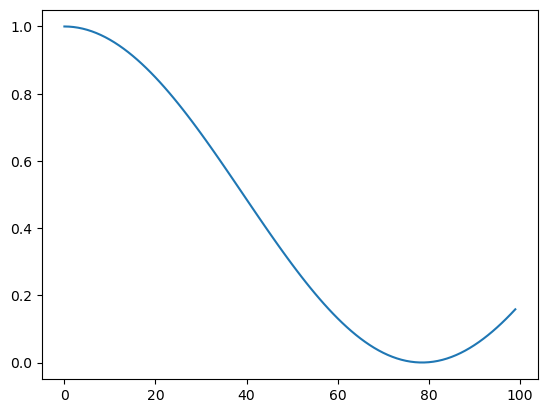

In [6]:
plot_probs([0.01, 0.01, 1], 'X^4', list(range(100)), '0', '0')

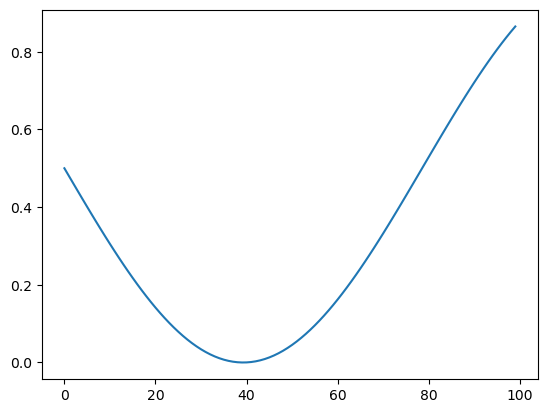

In [7]:
plot_probs([0.01, 0.01, 0], 'Y^4', list(range(100)), '+', '0')

# RPE classes def

In [8]:

class RPEDataGenerator:
    def __init__(self, depths=[1, ], compile_identity=False):
        self.depths = depths
        self.compile_identity = compile_identity

        self.meas_dict = {
            '0': np.array([1, 0]),
            '1': np.array([0, 1]),
            '+': (1/np.sqrt(2))*np.array([1, 1]),
            '-': (1/np.sqrt(2))*np.array([1, -1]),
            'R': (1/np.sqrt(2))*np.array([1, 1j]),
            'L': (1/np.sqrt(2))*np.array([1, -1j])
        }
        self.prep_dict = self.meas_dict.copy()

    def circ_to_prob(self, x, circ):
        gate = circ[0]
        d = circ[1]
        
        prep = circ[2]
        meas = circ[3]
        
        theta = x[0]
        phi = x[1]
        kappa = x[2]
        if gate == 'X':
            U_mat = model_Ux(theta)
        elif gate == 'X^4':
            Ux = model_Ux(theta)
            U_mat = np.linalg.matrix_power(Ux, 4)
        elif gate == 'Y':
            U_mat = model_Uy(phi, kappa)
        elif gate == 'Y^4':
            Uy = model_Uy(phi, kappa)
            U_mat = np.linalg.matrix_power(Uy, 4)
        elif gate == 'XYXY':
            Ux = model_Ux(theta)
            Uy = model_Uy(phi, kappa)
            U_mat = Ux @ Uy @ Ux @ Uy
        elif gate == 'XXYY':
            Ux = model_Ux(theta)
            Uy = model_Uy(phi, kappa)
            U_mat = Ux @ Ux @ Uy @ Uy
        else: 
            raise ValueError(f'Invalid gate with circ: {circ}')
        meas_vec = self.meas_dict[meas]
        prep_vec = self.prep_dict[prep]
        return np.abs(meas_vec @ np.linalg.matrix_power(U_mat, d) @ prep_vec)**2

    def circX_cos_probs(self, x, depths=None):
        if depths is None:
            depths = self.depths
        probs = []
        for d in depths:
            if self.compile_identity:
                probs.append(self.circ_to_prob(x, ('X^4', d, '0', '0')))
            else:
                probs.append(self.circ_to_prob(x, ('X', d, '0', '0')))
        return np.clip(probs, 0, 1)
    
    def circX_sin_probs(self, x, depths=None):
        if depths is None:
            depths = self.depths
        probs = []
        for d in depths:
            if self.compile_identity:
                probs.append(self.circ_to_prob(x, ('X^4', d, 'R', '0')))
            else:
                probs.append(self.circ_to_prob(x, ('X', d, 'R', '0')))
        return np.clip(probs, 0, 1)

    
    def circY_cos_probs(self, x, depths=None):
        if depths is None:
            depths = self.depths
        probs = []
        for d in depths:
            if self.compile_identity:
                probs.append(self.circ_to_prob(x, ('Y^4', d, '0', '0')))
            else:
                probs.append(self.circ_to_prob(x, ('Y', d, '0', '0')))
        return np.clip(probs, 0, 1)
    
    def circY_sin_probs(self, x, depths=None):
        if depths is None:
            depths = self.depths
        probs = []
        for d in depths:
            if self.compile_identity:
                probs.append(self.circ_to_prob(x, ('Y^4', d, '+', '0')))
            else:
                probs.append(self.circ_to_prob(x, ('Y', d, '+', '0')))
        return np.clip(probs, 0, 1)
    
    def circ_compiledZ_cos_probs(self, x, depths=None):
        if depths is None:
            depths = self.depths
        probs = []
        for d in depths:
            if self.compile_identity:
                raise NotImplementedError('Compiled Z not implemented for identity')
            else:
                probs.append(self.circ_to_prob(x, ('XXYY', d, '+', '+')))
        return np.clip(probs, 0, 1)

    def circ_compiledZ_sin_probs(self, x, depths=None):
        if depths is None:
            depths = self.depths
        probs = []
        for d in depths:
            if self.compile_identity:
                raise NotImplementedError('Compiled Z not implemented for identity')
            else:
                probs.append(self.circ_to_prob(x, ('XXYY', d, 'R', '+')))
        return np.clip(probs, 0, 1)
    
    def sample_circ_X_edesign(self, x, num_counts, depths=None):
        cos_probs = self.circX_cos_probs(x, depths)
        sin_probs = self.circX_sin_probs(x, depths)
        cos_0_counts = np.random.binomial(num_counts, cos_probs)
        sin_0_counts = np.random.binomial(num_counts, sin_probs)
        cos_counts = np.array([cos_0_counts, num_counts - cos_0_counts])
        sin_counts = np.array([sin_0_counts, num_counts - sin_0_counts])
        return cos_counts, sin_counts
    
    def sample_circ_Y_edesign(self, x, num_counts, depths=None):
        cos_probs = self.circY_cos_probs(x, depths)
        sin_probs = self.circY_sin_probs(x, depths)
        cos_0_counts = np.random.binomial(num_counts, cos_probs)
        sin_0_counts = np.random.binomial(num_counts, sin_probs)
        cos_counts = np.array([cos_0_counts, num_counts - cos_0_counts])
        sin_counts = np.array([sin_0_counts, num_counts - sin_0_counts])
        return cos_counts, sin_counts
    
    def sample_circ_compiledZ_edesign(self, x, num_counts, depths=None):
        cos_probs = self.circ_compiledZ_cos_probs(x, depths)
        sin_probs = self.circ_compiledZ_sin_probs(x, depths)
        cos_0_counts = np.random.binomial(num_counts, cos_probs)
        sin_0_counts = np.random.binomial(num_counts, sin_probs)
        cos_counts = np.array([cos_0_counts, num_counts - cos_0_counts])
        sin_counts = np.array([sin_0_counts, num_counts - sin_0_counts])
        return cos_counts, sin_counts
    
    def sample_dataset(self, x, num_counts, depths=None):
        cos_counts, sin_counts = self.sample_circ_X_edesign(x, num_counts, depths)
        cos_counts_y, sin_counts_y = self.sample_circ_Y_edesign(x, num_counts, depths)
        cos_counts_z, sin_counts_z = self.sample_circ_compiledZ_edesign(x, num_counts, depths)
        ds = {
            'X': {
                'cos': cos_counts,
                'sin': sin_counts
            },
            'Y': {
                'cos': cos_counts_y,
                'sin': sin_counts_y
            },
            'Z': {
                'cos': cos_counts_z,
                'sin': sin_counts_z
            }
        }
        return ds
    


In [9]:
def rectify_phase(phase):
    """
    Rectify phase to be between -pi and pi
    """
    return (phase + np.pi) % (2*np.pi) - np.pi

In [10]:
from quapack.pyRPE import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q as _rpeQ

class RPEAnalyzer():
    def estimate_1q_phase_from_raw_counts(self, cos_counts, sin_counts, depths):
        experiment = _rpeQ()
        for idx, d in enumerate(depths):
            if d == 0:
                continue
            experiment.process_cos(d, (int(cos_counts[0][idx]), int(cos_counts[1][idx])))
            experiment.process_sin(d, (int(sin_counts[0][idx]), int(sin_counts[1][idx])))
        analysis = RobustPhaseEstimation(experiment)
        last_good_generation = analysis.check_unif_local(historical=True)
        estimates = analysis.angle_estimates
        return estimates, last_good_generation
    
    def make_raw_estimates_and_last_good_gens(self, dataset, depths):
        circ_X_cos_counts = dataset['X']['cos']
        circ_X_sin_counts = dataset['X']['sin']
        circ_Y_cos_counts = dataset['Y']['cos']
        circ_Y_sin_counts = dataset['Y']['sin']
        cos_Zcompiled_counts = dataset['Z']['cos']
        sin_Zcompiled_counts = dataset['Z']['sin']


        x_estimates, last_good_generation_x = self.estimate_1q_phase_from_raw_counts(circ_X_cos_counts, circ_X_sin_counts, depths)
        y_estimates, last_good_generation_y = self.estimate_1q_phase_from_raw_counts(circ_Y_cos_counts, circ_Y_sin_counts, depths)
        z_estimates, last_good_generation_z = self.estimate_1q_phase_from_raw_counts(cos_Zcompiled_counts, sin_Zcompiled_counts, depths)
        return (x_estimates, y_estimates, z_estimates), (last_good_generation_x, last_good_generation_y, last_good_generation_z)
        
    def estimate_x(self, dataset, depths):
        (x_estimates, y_estimates, z_estimates), (last_good_generation_x, last_good_generation_y, last_good_generation_z) = self.make_raw_estimates_and_last_good_gens(dataset, depths)
        min_last_good_gen = min(last_good_generation_x, last_good_generation_y, last_good_generation_z)
        theta_best = x_estimates[min_last_good_gen]
        phi_best = y_estimates[min_last_good_gen]
        gamma_best = z_estimates[min_last_good_gen]
        x_theta = theta_best - np.pi/2 
        x_phi = -rectify_phase(phi_best) - np.pi/2
        x_gamma = -(np.arccos( np.sin(gamma_best) / (np.cos(x_theta) * np.cos(x_phi)) ) - np.pi/2)/2
        return np.array([x_theta, x_phi, x_gamma]), min_last_good_gen

# Dataset generation and analysis examples

In [11]:
# setup
x = (0.01)*np.random.randn(3)
gen = RPEDataGenerator()
depths = [2**i for i in range(15)]  

analyzer = RPEAnalyzer()

In [12]:
# estimate X circuit observations
cos_counts, sin_counts = gen.sample_circ_X_edesign(x, 1000, depths)
estimates, last_good_generation = analyzer.estimate_1q_phase_from_raw_counts(cos_counts, sin_counts, depths)
print(estimates, last_good_generation)

[1.59878901 1.591826   1.59576309 1.58540556 1.59035613 1.58913737
 1.58924026 1.58840786 1.58858711 1.58860935 1.58869399 1.58869268
 1.58869689 1.58869474 1.58869113] 14


In [13]:
# estimate Y circuit observations
cos_counts, sin_counts = gen.sample_circ_Y_edesign(x, 1000, depths)
estimates, last_good_generation = analyzer.estimate_1q_phase_from_raw_counts(cos_counts, sin_counts, depths)
print(estimates, last_good_generation)

[4.68439629 4.71738881 4.69281139 4.69916202 4.69868231 4.70070549
 4.70123914 4.70097477 4.70075707 4.70090177 4.70094384 4.7009388
 4.70093299 4.70093445 4.70093794] 14


In [14]:
# estimate Z circuit observations
cos_counts, sin_counts = gen.sample_circ_compiledZ_edesign(x, 1000, depths)
estimates, last_good_generation = analyzer.estimate_1q_phase_from_raw_counts(cos_counts, sin_counts, depths)
print(estimates, last_good_generation)

[3.1675868  3.11362187 3.15108808 3.14259263 3.13884443 3.13573969
 3.13748219 3.13711593 3.1370227  3.13720746 3.13723416 3.13718171
 3.13719157 3.13719395 3.13719617] 14


In [15]:
# all raw observations
ds = gen.sample_dataset(x, 1000, depths)
estimates, last_good_generation = analyzer.make_raw_estimates_and_last_good_gens(ds, depths)

In [16]:
# estimate x from dataset
x_est, last_good_gen = analyzer.estimate_x(ds, depths)
print(x_est, last_good_gen)

[0.0178944  0.01145223 0.00220152] 14


In [17]:
x

array([0.01789534, 0.01145303, 0.002405  ])

In [18]:
# calculate the error in the estimate for 1000 random normal vectors
# the error should be very small
errors = []
depths = [2**i for i in range(15)]
for _ in tqdm(range(1000)):
    x = (0.01)*np.random.randn(3)
    ds = gen.sample_dataset(x, 100, depths)
    x_est, lgg = analyzer.estimate_x(ds, depths)
    errors.append(np.linalg.norm(x - x_est))
np.mean(errors), np.std(errors)

100%|██████████| 1000/1000 [00:14<00:00, 66.86it/s]


(6.283649044405195e-05, 6.922064328232968e-05)

# Noise covariance estimation 

In [19]:
def make_random_covar(diag, off_diag_scale=0.1):
    A = np.diag(diag)
    A += off_diag_scale*np.random.randn(3, 3)

    A = (A + A.T)/2
    covar = np.dot(A, A.T)
    return covar

In [20]:
def estimate_Q(x):
    x_diff = np.diff(x, axis=0)
    Q = np.cov(x_diff.T)
    return Q

In [21]:
time_interval = 1
Q_0 = make_random_covar([0.01, 0.01, 0.01], 0.001)

# make a random initial state
x_0 = (0.01)*np.random.randn(3)
depths = [2**i for i in range(10)]

# sample, then step the state, then sample again 
num_samples = 1000
estimates = []
x_history = []
for n in tqdm(range(num_samples)):
    if n == 0:
        x = x_0
    else:
        x = x + np.random.multivariate_normal([0, 0, 0], Q_0*time_interval)
    x_history.append(x)

    ds = gen.sample_dataset(x, 1000, depths)
    x_est, lgg = analyzer.estimate_x(ds, depths)
    estimates.append(x_est)

x_history = np.array(x_history)
estimates = np.array(estimates)

100%|██████████| 1000/1000 [00:10<00:00, 99.93it/s]


In [22]:
estimate_Q(x_history)

array([[1.05492464e-04, 2.71265964e-06, 6.13688309e-06],
       [2.71265964e-06, 1.07771681e-04, 2.41300914e-06],
       [6.13688309e-06, 2.41300914e-06, 1.16066400e-04]])

In [23]:
Q_0

array([[ 1.05893168e-04,  2.13499400e-06,  5.10062487e-06],
       [ 2.13499400e-06,  9.77273012e-05, -6.64499592e-07],
       [ 5.10062487e-06, -6.64499592e-07,  1.04579038e-04]])

In [24]:
estimate_Q(estimates)   

array([[ 1.05835139e-04,  2.49647332e-06, -1.40134657e-05],
       [ 2.49647332e-06,  1.08149806e-04,  3.66606787e-05],
       [-1.40134657e-05,  3.66606787e-05,  1.53542464e-04]])

In [25]:
# error in covar estimate
np.linalg.norm(estimate_Q(x_history) - Q_0), np.linalg.norm(estimate_Q(estimates) - Q_0)

(1.5961415541163858e-05, 7.761021310759956e-05)

# Demo of control-free estimation with Kalman on top of RPE

Can we derive an optimal time to re-estimate? 


In this case, we assume a very simple model, where 
$$
    y_k = x_k + v_k
$$
and 
$$
    x_{k+1} = x_k + w_k
$$
where 
$$
    v_k \sim \mathcal{N}(0, R)
$$
and 
$$
    w_k \sim \mathcal{N}(0, Q). 
$$

Let 
$$
    R = \frac{\pi}{d} 
$$
and 
$$
    Q = Q_0. 
$$

Then, the Kalman gain is 
$$
    K_k = P_{k|k-1} (P_{k|k-1} + R)^{-1} 
$$
and the update is 
$$
    \hat{x}_{k|k} = \hat{x}_{k-1|k-1} + K_k (y_k - \hat{x}_{k-1|k-1})
$$

In [26]:
def calc_kalman_gain(P, R):
    return P @ np.linalg.inv(P + R)

def step_state(x, Q):
    return x + np.random.multivariate_normal(np.zeros(3), Q)

def make_R(max_depth):
    return np.diag([np.pi/(2*max_depth**2)]*3)

In [27]:
make_R(depths[-1])

array([[5.99211245e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 5.99211245e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 5.99211245e-06]])

In [28]:
x0 = np.zeros(3)
Q = make_random_covar([0.0001, 0.0001, 0.0001], 1e-4)
depths = [2**i for i in range(10)]

num_steps = 100

x_history = np.zeros((num_steps, 3))
estimate_history = np.zeros((num_steps, 3))
raw_rpe_history = np.zeros((num_steps, 3))

kalman_estimate = np.zeros(3)

for i in tqdm(range(num_steps)):
    if i == 0:
        x = x0 
    else:
        x = step_state(x, Q)
    x_history[i] = x
    ds = gen.sample_dataset(x, 100, depths)
    x_est, last_good_gen = analyzer.estimate_x(ds, depths)
    raw_rpe_history[i] = x_est
    if i == 0: 
        P = make_R(depths[last_good_gen])
    else:
        P = P + Q
    R = make_R(depths[last_good_gen])
    K = calc_kalman_gain(P, R)
    kalman_estimate = kalman_estimate + K @ (x_est - kalman_estimate)
    estimate_history[i] = kalman_estimate


100%|██████████| 100/100 [00:01<00:00, 96.40it/s]


In [29]:
def rmse(x, x_hat):
    return np.sqrt(np.mean((x - x_hat)**2))

In [30]:
rmse(x_history, estimate_history)

0.00015028595816807115

In [31]:
rmse(x_history, raw_rpe_history)

0.00015388658639741806

In [32]:
# plot the rmse of the kalman filter vs the raw RPE as a function of the R coef
x0 = np.zeros(3)
Q = make_random_covar([0.00001, 0.00001, 0.00001], 1e-6)
depths = [2**i for i in range(10)]
R_coefs = list(range(-5, 5))
Rs = [make_R(depths[-1]*2**k) for k in R_coefs]

num_steps = 1000

x_history = np.zeros((len(Rs), num_steps, 3))
estimate_history = np.zeros((len(Rs), num_steps, 3))
raw_rpe_history = np.zeros((len(Rs), num_steps, 3))

kalman_estimate = np.zeros(3)

for idx, R in enumerate(tqdm(Rs)):
    for i in range(num_steps):
        if i == 0:
            x = x0 
        else:
            x = step_state(x, Q)
        x_history[idx, i] = x
        ds = gen.sample_dataset(x, 100, depths)
        x_est, last_good_gen = analyzer.estimate_x(ds, depths)
        raw_rpe_history[idx, i] = x_est
        if i == 0: 
            P = R
        else:
            P = P + Q
        K = calc_kalman_gain(P, R)
        kalman_estimate = kalman_estimate + K @ (x_est - kalman_estimate)
        estimate_history[idx, i] = kalman_estimate


100%|██████████| 10/10 [01:36<00:00,  9.61s/it]


In [33]:
R_coefs

[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4]

Text(0.5, 0, 'R coef index [log2]')

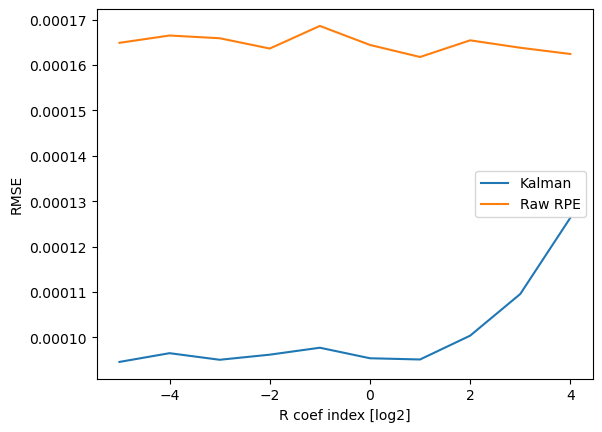

In [34]:
plt.plot(R_coefs, [rmse(x_history[i], estimate_history[i]) for i in range(len(Rs))])
plt.plot(R_coefs, [rmse(x_history[i], raw_rpe_history[i]) for i in range(len(Rs))])
plt.legend(['Kalman', 'Raw RPE'])
# add axis labels
plt.ylabel('RMSE')
plt.xlabel('R coef index [log2]')

# Control model noise free estimation 

In [35]:
def select_random_control(covar):
    return np.random.multivariate_normal(np.zeros(3), covar)

In [36]:
# make a trajectory with a random control
x_0 = np.zeros(3)
Q = 0*make_random_covar([0.00001, 0.00001, 0.00001], 1e-6)
control_covar = make_random_covar([0.001, 0.001, 0.001], 0)

B = np.diag(np.random.randn(3))

depths = [2**i for i in range(10)]
R = make_R(depths[-1])

num_steps = 50
x_history = np.zeros((num_steps, 3))
raw_rpe_history = np.zeros((num_steps, 3))
control_history = np.zeros((num_steps-1, 3))

x_history[0] = x_0

DS = gen.sample_dataset(x_0, 100, depths)
x_est, last_good_gen = analyzer.estimate_x(DS, depths)
raw_rpe_history[0] = x_est

x = x_0


for n in tqdm(range(1, num_steps)):
    control = select_random_control(control_covar)
    control_history[n-1] = control
    
    x = x + B @ control     
    x_history[n] = x
    
    ds = gen.sample_dataset(x, 100, depths)
    x_est, last_good_gen = analyzer.estimate_x(ds, depths)
    raw_rpe_history[n] = x_est


100%|██████████| 49/49 [00:00<00:00, 97.20it/s]


In [37]:
from scipy.optimize import least_squares

def cost_fun(B, x_history, control_history):
    x_hats = np.zeros((len(control_history), 3))
    B_mat = np.reshape(B, (3, 3))
    x_hat = x_history[0]
    for idx, control in enumerate(control_history):
        x_hat = x_hat + B_mat @ control
        x_hats[idx] = x_hat
    return np.linalg.norm(x_hats - x_history[1:])

def estimate_B(x_history, control_history):
    res = least_squares(cost_fun, np.zeros((9)), args=(x_history, control_history))
    return res.x

In [38]:
control_history.shape

(49, 3)

In [39]:
B_est_from_true_traj = estimate_B(x_history, control_history)
B_est_from_true_traj = np.reshape(B_est_from_true_traj, (3, 3))
np.linalg.norm(B - np.reshape(B_est_from_true_traj, (3, 3)))

0.00014407977955133486

In [40]:
B_est_from_true_traj

array([[-1.89976612e+00,  6.52245610e-05, -4.01093660e-05],
       [ 5.89282394e-05, -1.71086885e+00, -2.84065568e-05],
       [-2.66919043e-05, -2.08965846e-05, -1.27444467e+00]])

In [41]:
B_est = estimate_B(raw_rpe_history, control_history)

In [42]:
B_est = np.reshape(B_est, (3, 3))

In [43]:
B_est

array([[-1.93085954e+00, -2.71305680e-03,  2.39416674e-02],
       [ 5.45225204e-02, -1.68411214e+00, -2.81421890e-02],
       [-2.03795378e-04,  1.68431454e-02, -1.28613723e+00]])

In [44]:
B

array([[-1.89984939,  0.        ,  0.        ],
       [ 0.        , -1.7109175 ,  0.        ],
       [ 0.        ,  0.        , -1.27445761]])

In [45]:
np.linalg.norm(B - B_est)

0.08028421603635687

# Estimating the control and noise covariance

First, we fit $B$ with least squares, then we fit $Q$ to the residual

In [46]:
def make_trajectory(x0, A, B, Q, depths, controls=None, num_steps=100, num_shots=100):
    x = x0
    x_history = [x]
    
    ds = gen.sample_dataset(x, num_shots, depths)
    x_hat, lgg = analyzer.estimate_x(ds, depths)
    x_hat_history = [x_hat]
    lgg_history = [lgg]
    
    control_history = []
    for i in range(num_steps):
        u = controls[i]
        x = A @ x + B @ u + np.random.multivariate_normal(np.zeros(3), Q)

        ds = gen.sample_dataset(x, num_shots, depths)
        x_hat, lgg = analyzer.estimate_x(ds, depths)

        x_history.append(x)
        x_hat_history.append(x_hat)
        lgg_history.append(lgg)
        control_history.append(u)
    return np.array(x_history), np.array(x_hat_history), np.array(control_history), np.array(lgg_history)


In [47]:
x0 = np.zeros(3)
A = np.eye(3)
B = np.diag([0.1, 5, 1])
Q = make_random_covar([0.001, 0.001, 0.001], 1e-4)
depths = [2**i for i in range(10)]

controls = [0.01*np.random.randn(3) for _ in range(100)]
x_history, x_hat_history, control_history, lgg_history = make_trajectory(x0, A, B, Q, depths, controls)

In [48]:
rmse(x_history, x_hat_history)

0.00039434065114988084

In [49]:
len(x_history), len(control_history)

(101, 100)

In [50]:
B

array([[0.1, 0. , 0. ],
       [0. , 5. , 0. ],
       [0. , 0. , 1. ]])

In [51]:
Bhat = estimate_B(x_hat_history, control_history)
np.reshape(Bhat, (3, 3))

array([[ 0.12004519,  0.09018333, -0.03607675],
       [ 0.09615871,  5.03583372, -0.10849824],
       [ 0.01065422,  0.02699997,  1.00692343]])

In [57]:
Bhat = np.reshape(Bhat, (3, 3))
np.linalg.norm(B - Bhat)

0.16746652175812426

In [58]:
# now estimate Q from the resuiduals
residuals = x_hat_history - x_history
Q_hat = np.cov(residuals.T)

In [59]:
np.linalg.norm(Q - Q_hat)

1.3228115368353565e-05

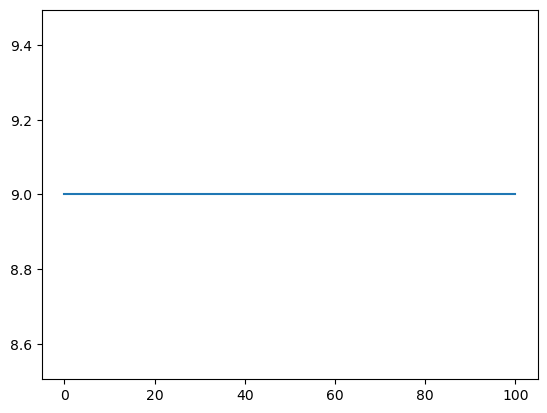

In [60]:
plt.plot(lgg_history)

# Infinite Horizon LQG with known B


In [82]:
from scipy.optimize import least_squares

def cost_fun(B, x_history, control_history):
    x_hats = np.zeros((len(control_history), 3))
    B_mat = np.reshape(B, (3, 3))
    x_hat = x_history[0]
    for idx, control in enumerate(control_history):
        x_hat = x_hat + B_mat @ control
        x_hats[idx] = x_hat
    return np.linalg.norm(x_hats - x_history[1:])

def estimate_B(x_history, control_history):
    res = least_squares(cost_fun, np.zeros((9)), args=(x_history, control_history))
    return res.x

In [83]:
import scipy.linalg as la

def discrete_infinite_horizon_lqg(A, B, Q, R):
    """
    Calculates the infinite horizon LQG control in a discrete setting.

    Args:
        A: State matrix.
        B: Input matrix.
        Q: State cost matrix.
        R: Input cost matrix.

    Returns:
        K: The optimal feedback gain matrix.
        P: The solution to the discrete algebraic Riccati equation (DARE).
    """

    # Solve the discrete algebraic Riccati equation (DARE)
    P = la.solve_discrete_are(A, B, Q, R)

    # Calculate the optimal feedback gain matrix
    K = la.inv(R + B.T @ P @ B) @ B.T @ P @ A

    return K, P

In [84]:
def plot_trajectories(trajectores, labels=None):
    fig, ax = plt.subplots(3, 1, figsize=(10, 10))
    for traj in trajectores:
        for i in range(3):
            ax[i].plot(traj[:, i])
    if labels is not None:
        for i in range(3):
            ax[i].legend(labels)
    plt.show()

In [85]:
import scipy

In [86]:
import control

In [87]:
np.linalg.matrix_rank(control.ctrb(A, B))

3

In [88]:
make_R(1024)

array([[1.49802811e-06, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.49802811e-06, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.49802811e-06]])

In [89]:
def calc_kalman_gain(P, R):
    return P @ np.linalg.inv(P + R)

In [75]:
P0 = 1e-5*np.eye(3)
x0 = np.random.multivariate_normal(np.zeros(3), P0)

Q = make_random_covar([0.0001, 0.0001, 0.0001], 1e-4)
A = np.eye(3)
B = np.diag([0.1, 0.3, 0.5])

depths = [2**i for i in range(10)]

num_shots = 100
num_steps = 1000

x_history = np.zeros((num_steps, 3))
x_hat_history = np.zeros((num_steps, 3))
y_history = np.zeros((num_steps, 3))
control_history = np.zeros((num_steps, 3))
lgg_history = np.zeros(num_steps)
P_history = np.zeros((num_steps, 3, 3))

x_free_control_history = np.zeros((num_steps, 3))
x_free_control_history[0] = x0

# step 0 
x = x0
x_history[0] = x
ds = gen.sample_dataset(x, num_shots, depths)
y_rpe, lgg = analyzer.estimate_x(ds, depths)
y_history[0] = y_rpe
x_hat_history[0] = y_rpe
lgg_history[0] = lgg
P = make_R(depths[lgg])
P_history[0] = P

# step the state (no initial control)
w = np.random.multivariate_normal(np.zeros(3), Q)
x = x  + w
control_history[0] = np.zeros(3)

# step 1 to num_steps
for i in tqdm(range(1, num_steps)):
    x_history[i] = x
    
    # observe and record
    ds = gen.sample_dataset(x, num_shots, depths)
    y_rpe, lgg = analyzer.estimate_x(ds, depths)
    y_history[i] = y_rpe
    lgg_history[i] = lgg
    

    # Kalman filter state update
    
    # prediction
    x_hat = x_hat_history[i-1]
    x_hat = A @ x_hat + B @ control_history[i-1]
    P = A @ P @ A.T + Q 

    # update
    R = make_R(depths[lgg])*2**-5
    K = calc_kalman_gain(P, R)
    x_hat = x_hat + K @ (y_rpe - x_hat)
    P = (np.eye(3) - K) @ P

    x_hat_history[i] = x_hat
    P_history[i] = P

    # select optimal control
    P = P_history[i-1]
    x_hat = x_hat_history[i-1]
    try:
        G_optimal, _ = discrete_infinite_horizon_lqg(A, B, Q, 1e-15*np.eye(3))
    except:
        print(f'Error at step {i}')
    u_optimal = -G_optimal@y_rpe
    control_history[i] = u_optimal

    # step the state
    w = np.random.multivariate_normal(np.zeros(3), Q)
    x = x + B@u_optimal + w

    # also step the state without control
    x_free_control_history[i] = x_free_control_history[i-1] + w    

    # # B estimation
    # if i > 3:
    #     Bhat = estimate_B(y_history[:i], x0, control_history[1:i])
    # else:
    #     Bhat = Bhat_history[i-1]
    # Bhat_history[i] = np.reshape(Bhat, (3, 3))


  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 999/999 [00:11<00:00, 90.28it/s]


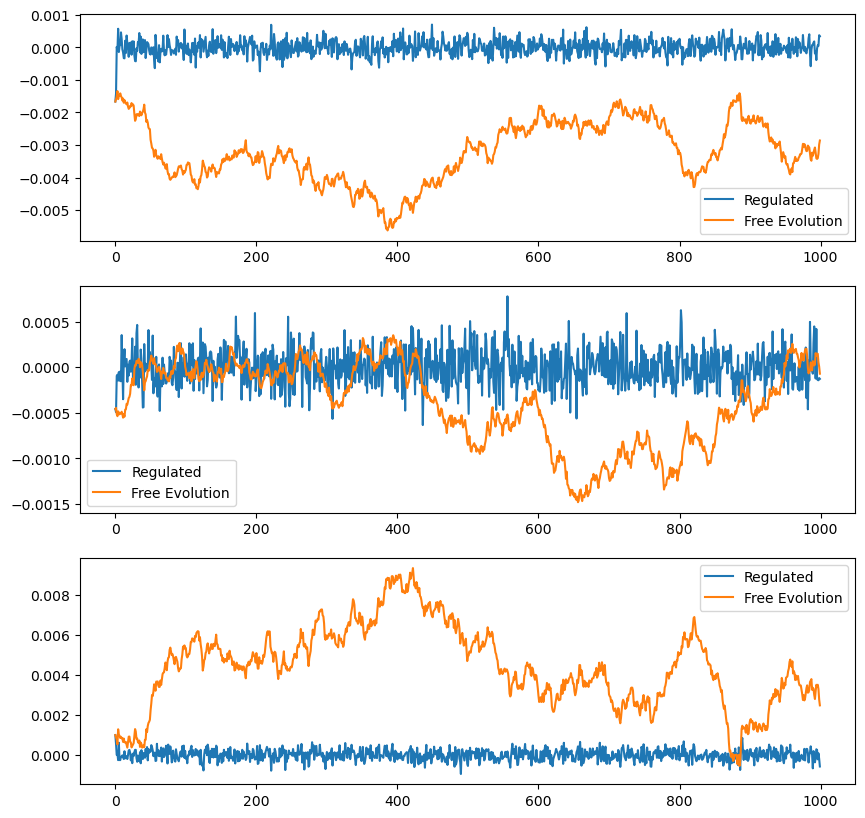

In [79]:
plot_trajectories([x_history, x_free_control_history], ['Regulated', 'Free Evolution'])

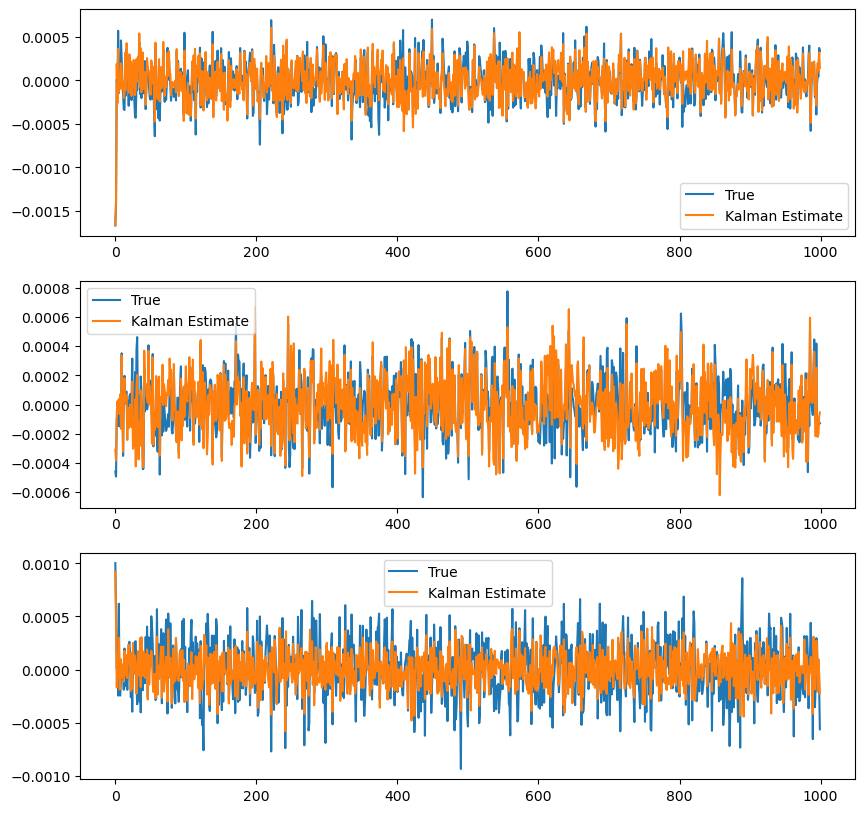

In [80]:
plot_trajectories([x_history, x_hat_history], ['True', 'Kalman Estimate'])

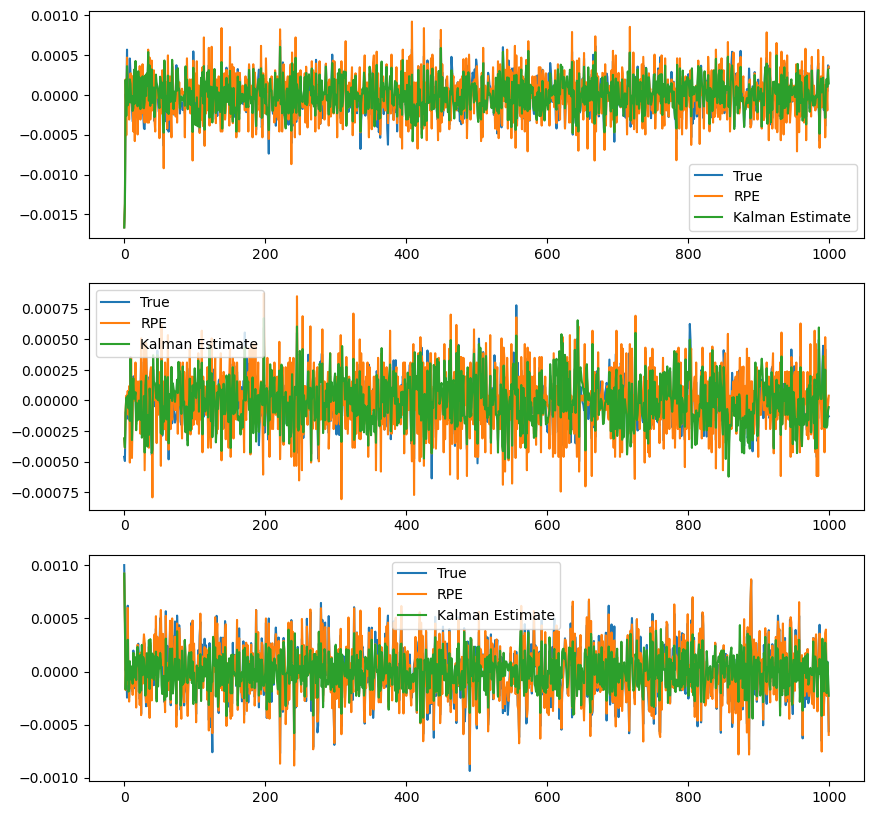

In [81]:
plot_trajectories([x_history, y_history, x_hat_history], ['True', 'RPE', 'Kalman Estimate'])

# K-step LQR

In [109]:
def riccati_recursion(P, B, M, N, S):
    return M + P - (S.T + B.T @ P).T @ np.linalg.inv(N + B.T @ P @ B) @ (S.T + B.T @ P) 

def K_step_riccati_covar_series(K, PK, B, M, N, S):
    covars = [PK]
    for k in range(K-1):
        PK = riccati_recursion(PK, B, M, N, S)
        covars.append(PK)
    # return the reverse
    return covars[::-1]

def calc_lqr_gain(P, B, M, N, S):
    return np.linalg.inv(N + B.T @ P @ B) @ (S.T + B.T @ P)

In [145]:
# Define the control model 
B = np.diag([0.1, 0.3, 0.5])

# Define the state model
A = np.eye(3)



# LQR cost matrices
state_cost_N = np.eye(3)
input_cost_M = 1e-6*np.eye(3)
cross_cost_S = np.zeros((3, 3))

# K 
num_steps = 10

# Final state cost
P = state_cost_N

In [126]:
# Sample initial state
P0 = 1e-5*np.eye(3)
x0 = np.random.multivariate_normal(np.zeros(3), P0)

# calc Riccati recursion
riccati_covar_series = K_step_riccati_covar_series(num_steps, P, B, input_cost_M, state_cost_N, cross_cost_S)
print(riccati_covar_series)

[array([[10.0000384 ,  0.        ,  0.        ],
       [ 0.        ,  1.21954775,  0.        ],
       [ 0.        ,  0.        ,  0.44251319]]), array([[11.11114617,  0.        ,  0.        ],
       [ 0.        ,  1.36989525,  0.        ],
       [ 0.        ,  0.        ,  0.49754444]]), array([[12.50003172,  0.        ,  0.        ],
       [ 0.        ,  1.56252893,  0.        ],
       [ 0.        ,  0.        ,  0.56821052]]), array([[14.28574265,  0.        ,  0.        ],
       [ 0.        ,  1.81820745,  0.        ],
       [ 0.        ,  0.        ,  0.66227706]]), array([[16.66669167,  0.        ,  0.        ],
       [ 0.        ,  2.1739354 ,  0.        ],
       [ 0.        ,  0.        ,  0.79367292]]), array([[20.0000216 ,  0.        ,  0.        ],
       [ 0.        ,  2.7027218 ,  0.        ],
       [ 0.        ,  0.        ,  0.99011788]]), array([[25.00001812,  0.        ,  0.        ],
       [ 0.        ,  3.57144445,  0.        ],
       [ 0.        ,  0.   

In [127]:
# allocate saving space
x_history = np.zeros((num_steps+1, 3))
u_history = np.zeros((num_steps, 3))

# step 0 
P0 = riccati_covar_series[0]
G0 = calc_lqr_gain(P0, B, input_cost_M, state_cost_N, cross_cost_S)
u0 = -G0 @ x0

x = x0 + B @ u0

x_history[0] = x0
x_history[1] = x
u_history[0] = u0


# step 1 to num_steps
for i in tqdm(range(1, num_steps)):
    P = riccati_covar_series[i]
    G = calc_lqr_gain(P, B, input_cost_M, state_cost_N, cross_cost_S)
    u = -G @ x
    u_history[i] = u

    x = x + B @ u
    x_history[i+1] = x
    

100%|██████████| 9/9 [00:00<00:00, 9475.08it/s]


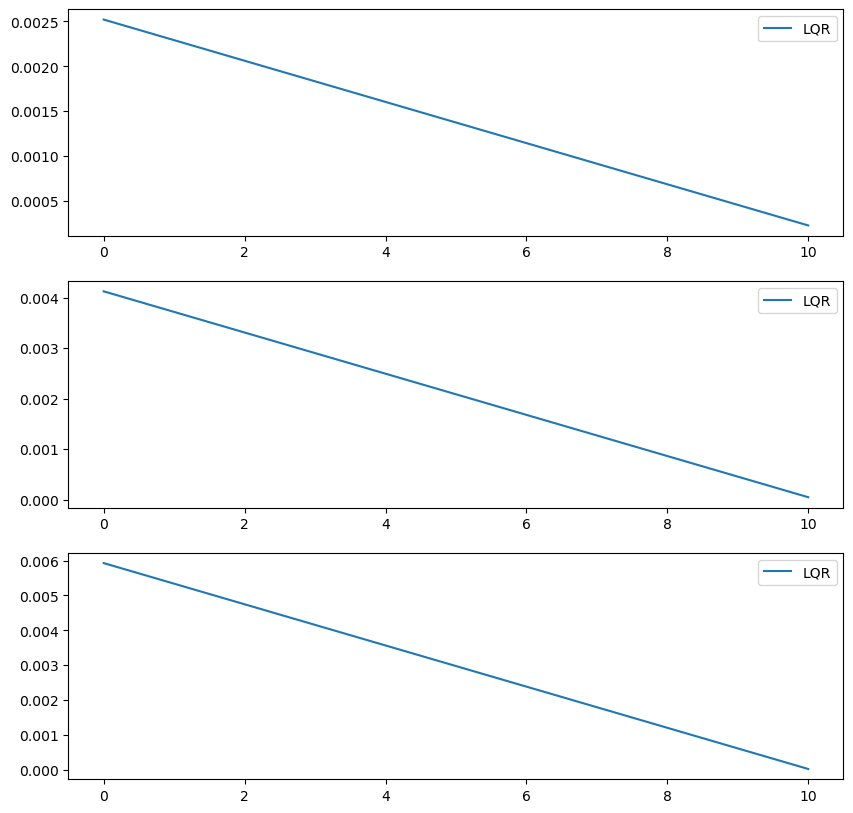

In [128]:
plot_trajectories([x_history], ['LQR'])

# LQR with RPE observations

In [147]:
# Define the control model 
B = np.diag([0.1, 0.3, 0.5])

# Define the state model
A = np.eye(3)


# K 
num_steps = 10

# Final state cost
P = state_cost_N

# depths 
depths = [2**i for i in range(10)]
num_samples = 100

# LQR cost matrices
state_cost_N = np.eye(3)
input_cost_M = make_R(2**(len(depths)-1))
cross_cost_S = np.zeros((3, 3))


In [159]:
# Sample initial state
P0 = 1e-2*np.eye(3)
x0 = np.random.multivariate_normal(np.zeros(3), P0)
print(x0)

# calc Riccati recursion
riccati_covar_series = K_step_riccati_covar_series(num_steps, P, B, input_cost_M, state_cost_N, cross_cost_S)

# allocate saving space
x_history = np.zeros((num_steps+1, 3))
u_history = np.zeros((num_steps, 3))

# step 0 
P0 = riccati_covar_series[0]
G0 = calc_lqr_gain(P0, B, input_cost_M, state_cost_N, cross_cost_S)
u0 = -G0 @ x0

x = x0 + B @ u0

x_history[0] = x0
x_history[1] = x
u_history[0] = u0


# step 1 to num_steps
for i in tqdm(range(1, num_steps)):
    P = riccati_covar_series[i]
    ds = gen.sample_dataset(x, num_samples, depths)
    x_est, lgg = analyzer.estimate_x(ds, depths)

    G = calc_lqr_gain(P, B, input_cost_M, state_cost_N, cross_cost_S)
    u = -G @ x_est
    u_history[i] = u

    x = x + B @ u
    x_history[i+1] = x

[ 0.15882735  0.02147503 -0.08908693]


100%|██████████| 9/9 [00:00<00:00, 71.22it/s]


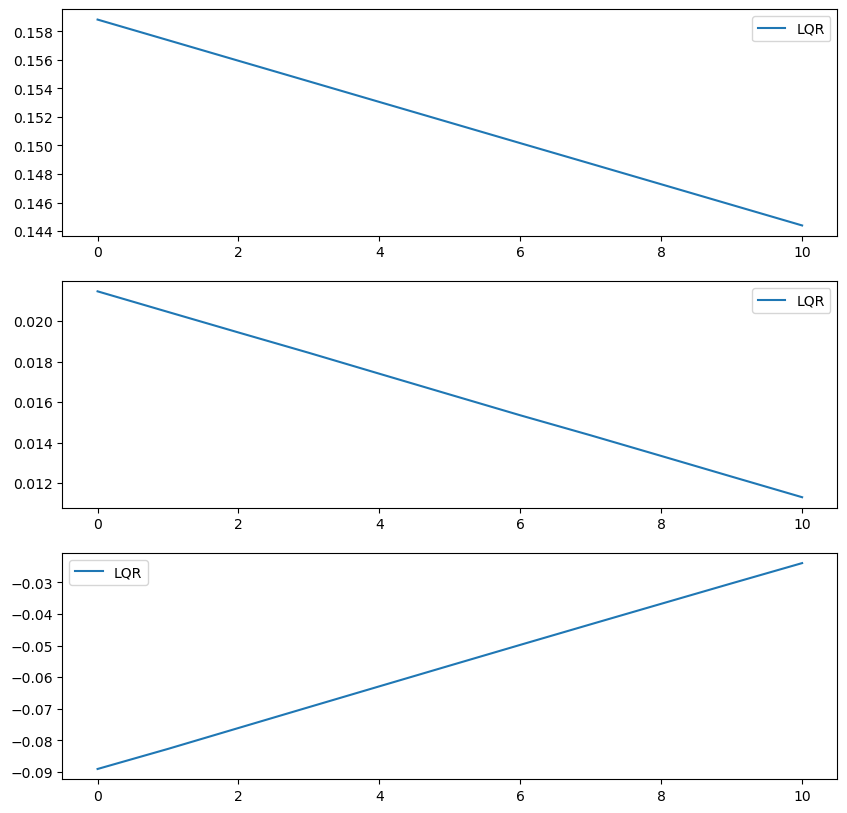

In [160]:
plot_trajectories([x_history], ['LQR'])

## Many trajectories

In [169]:
def sample_trajectories_series_from_fixed_start(x0, num_trajs, num_shots_per_circ, depths, num_steps_in_lqr, final_state_cost, B, M, N, S):
    xs = np.zeros((num_trajs, num_steps_in_lqr+1, 3))
    us = np.zeros((num_trajs, num_steps_in_lqr, 3))
    ys = np.zeros((num_trajs, num_steps_in_lqr+1, 3))
    riccati_covar_series = K_step_riccati_covar_series(num_steps_in_lqr, final_state_cost, B, M, N, S)
    for i in tqdm(range(num_trajs)):
        for j in range(num_steps_in_lqr+1):
            if j == 0:
                x = x0
            else:
                x = x + B @ us[i, j-1]
            xs[i, j] = x
            ds = gen.sample_dataset(x, num_shots_per_circ, depths)
            y, _ = analyzer.estimate_x(ds, depths)
            ys[i, j] = y
            if j < num_steps_in_lqr:
                G = calc_lqr_gain(riccati_covar_series[j], B, M, N, S)
                u = -G @ y
                us[i, j] = u
    return xs, ys, us


In [226]:
# Define the control model 
B = np.diag([0.1, 0.3, 0.5])

# Define the state model
A = np.eye(3)


# K
num_steps = 16

# Final state cost
P = state_cost_N

# depths 
depths = [2**i for i in range(12)]
num_samples = 100

# LQR cost matrices
state_cost_N = np.eye(3)
input_cost_M = make_R(2**(len(depths)-1))
cross_cost_S = np.zeros((3, 3))
final_state_cost = state_cost_N*1000


In [227]:
input_cost_M

array([[3.74507028e-07, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 3.74507028e-07, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.74507028e-07]])

In [228]:
x0 = np.array([0.1, 0.2, 0.3])
num_trajs = 30
xs, ys, us = sample_trajectories_series_from_fixed_start(x0, num_trajs, num_samples, depths, num_steps, B, final_state_cost, input_cost_M, state_cost_N, cross_cost_S)

100%|██████████| 30/30 [00:05<00:00,  5.05it/s]


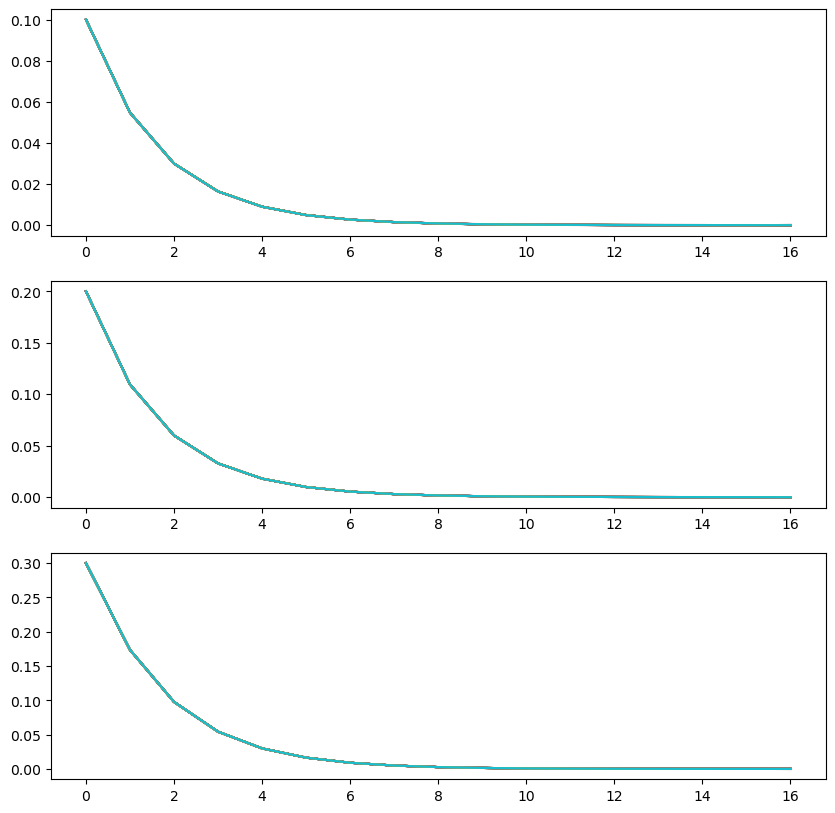

In [229]:
plot_trajectories(xs)

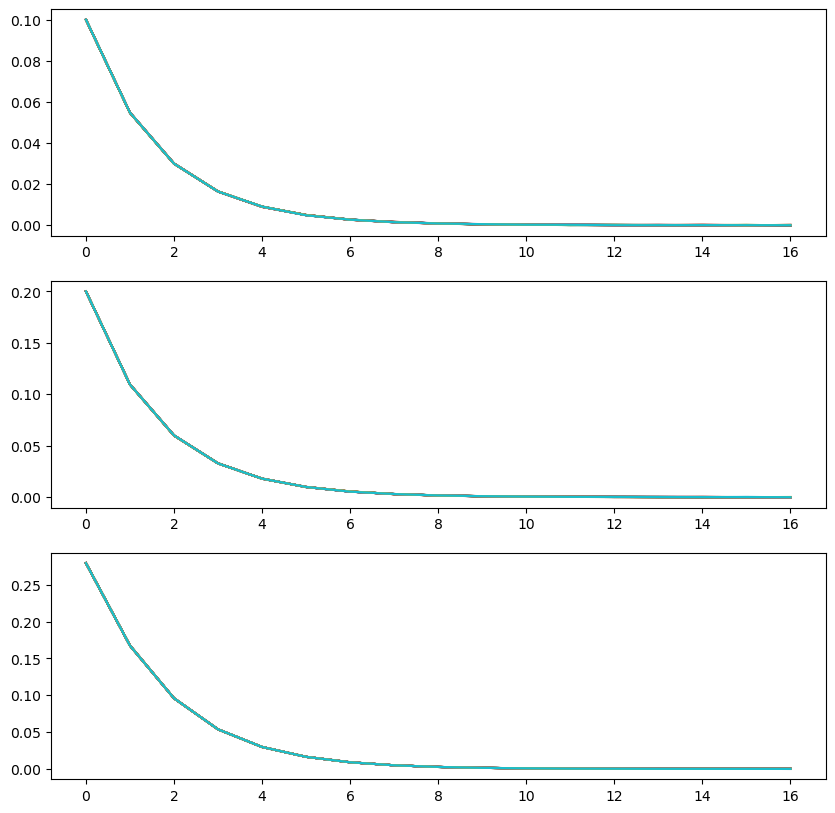

In [230]:
plot_trajectories(ys)

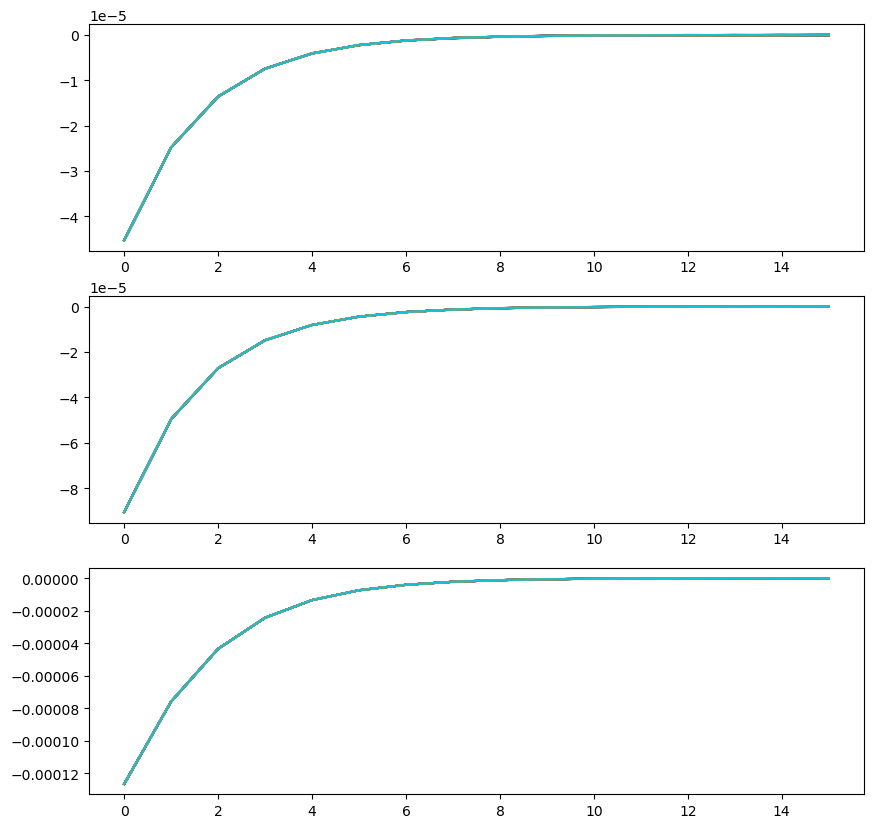

In [231]:
plot_trajectories(us)

# Dual filtering for the control model 

In [146]:
def select_controls(num_controls, control_covar):
    """
    Sample num_controls controls from a multivariate normal distribution with covariance control_covar
    Resample until the controls are linearly independent
    """
    assert num_controls > 3
    sample = np.random.multivariate_normal(np.zeros(3), control_covar, num_controls)
    while np.linalg.matrix_rank(sample) < 3:
        sample = np.random.multivariate_normal(np.zeros(3), control_covar, num_controls)
    return sample

def make_x_traj(x0, controls, B, Q, depths, num_shots=100):
    x = x0
    x_history = []
    w_history = []
    for control in controls:
        w = np.random.multivariate_normal(np.zeros(3), Q)
        x = x + B @ control + w
        w_history.append(w)
        x_history.append(x)
    return np.array(x_history), np.array(w_history)

def format_dual_state_and_observation(ys, controls):
    """
    Format the dual state for the Kalman filter
    """
    assert len(ys) == len(controls) + 1
    z = np.diff(ys, axis=0).flatten()
    Us = []
    for i, control in enumerate(controls):
        u = np.reshape(control, (1, 3))
        U = np.kron(np.eye(3), u)
        Us.append(U)
    Us = np.vstack(Us)
    return z, Us


In [283]:
# this cell demonstrates the control estimation with direct least squares
depths = [2**i for i in range(20)]
num_shots = 1000
control_covar = make_random_covar([0.1, 0.1, 0.1], 0.01)
controls = select_controls(10, control_covar)

Q = 0*make_random_covar([1e-5, 1e-5, 1e-5], 1e-6)

B = np.diag([0.1, 0.3, 0.5])

x0 = np.zeros(3)

ds0 = gen.sample_dataset(x0, num_shots, depths)
y0, lgg = analyzer.estimate_x(ds0, depths)

controls = select_controls(10, control_covar)
x_traj, w_traj = make_x_traj(x0, controls, B, Q, depths)
ys = [y0]
xs = [x0]
lggs = [lgg]
for x in x_traj:
    ds = gen.sample_dataset(x, num_shots, depths)
    y, lgg = analyzer.estimate_x(ds, depths)
    ys.append(y)
    xs.append(x)
    lggs.append(lgg)


z, U = format_dual_state_and_observation(ys, controls)

# estimate B with direct least squares
B_est = np.linalg.lstsq(U, z, rcond=None)[0]
B_est = np.reshape(B_est, (3, 3))


print("Error in state estimate", np.linalg.norm(np.array(xs) - np.array(ys)))
print("last good gens", lggs )
print("Error in B estimate", np.linalg.norm(B - B_est))


z_x, U_x = format_dual_state_and_observation(xs, controls)
B_est_x = np.linalg.lstsq(U_x, z_x, rcond=None)[0]
B_est_x = np.reshape(B_est_x, (3, 3))
print("Error in B estimate with true traj", np.linalg.norm(B - B_est_x))

Error in state estimate 0.0024435156810381723
last good gens [19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
Error in B estimate 0.00526072022274977
Error in B estimate with true traj 2.4266050146529936e-16


In [285]:
import scipy.linalg


def make_dual_kalman_gain(P, R, U):
    """
    Calculate the Kalman gain for the dual state
    """
    return P @ U.T @ np.linalg.inv(U @ P @ U.T + R)

def make_dual_R(max_depth, control_order):
    return scipy.linalg.block_diag(*[np.diag([np.pi/(2*max_depth**2)]*3) for _ in range(control_order)])

def make_dual_Q(Q, control_order):
    return scipy.linalg.block_diag(*[Q for _ in range(control_order)])

In [288]:
def make_random_covar(num_states, diagonal_scale=0.1, off_diag_scale=0.1):
    A = np.diag([diagonal_scale]*num_states)
    A += off_diag_scale*np.random.randn(num_states, num_states)

    A = (A + A.T)/2
    covar = np.dot(A, A.T)
    return covar

In [314]:
P0 = np.eye(9)
B_0 = np.ones(9)*0.1
Q_dual = make_random_covar(9, 1e-5, 1e-6)

In [328]:
# no state drift, only control drift

num_observations = 1000
x0 = np.zeros(3)
y0_ds = gen.sample_dataset(x0, num_shots, depths)
y0, lgg = analyzer.estimate_x(y0_ds, depths)
num_controls = 5
B = np.diag([0.1, 0.3, 0.5])

Bs = [B.flatten()]
Ps = [P0]
B_hats = [B_0]

Bvec = B.flatten()

for k in tqdm(range(num_observations)):
    controls = select_controls(num_controls, control_covar)
    B = np.reshape(Bvec, (3, 3))
    x_traj, w_traj = make_x_traj(x0, controls, B, Q, depths)

    ys = [y0] 
    for x in x_traj:
        ds = gen.sample_dataset(x, num_shots, depths)
        y, _ = analyzer.estimate_x(ds, depths)
        ys.append(y)
    z, U = format_dual_state_and_observation(ys, controls)

    # Kalman filter update
    if k == 0:
        P_dual = P0
        B_hat = B_0
    else:
        P_dual = P_dual + Q_dual
    R_dual = make_dual_R(depths[lgg], num_controls)
    K_dual = make_dual_kalman_gain(P_dual, R_dual, U)

    B_hat = B_hat + K_dual @ (z - U @ B_hat)
    P_dual = (np.eye(9) - K_dual @ U) @ P_dual

    Bs.append(Bvec)
    Ps.append(P_dual)
    B_hats.append(B_hat)

    Bvec = Bvec + np.random.multivariate_normal(np.zeros(9), Q_dual)
    

    

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:49<00:00, 20.07it/s]


In [329]:
# average error in B estimate
np.mean([np.linalg.norm(B - np.reshape(B_hat, (3, 3))) for B_hat in B_hats])

0.0011129606707802556

In [330]:
np.linalg.norm(B - np.reshape(B_0, (3, 3)))

0.509591681413338

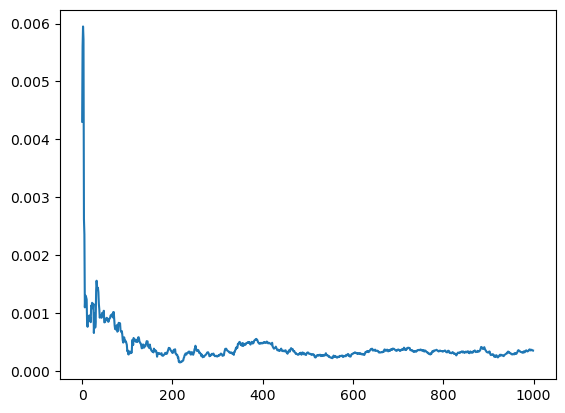

In [352]:
# plot the error over time 
plt.plot([np.linalg.norm(np.reshape(B, (3,3)) - np.reshape(B_hat, (3, 3))) for B, B_hat in zip(Bs[1:], B_hats[1:])])

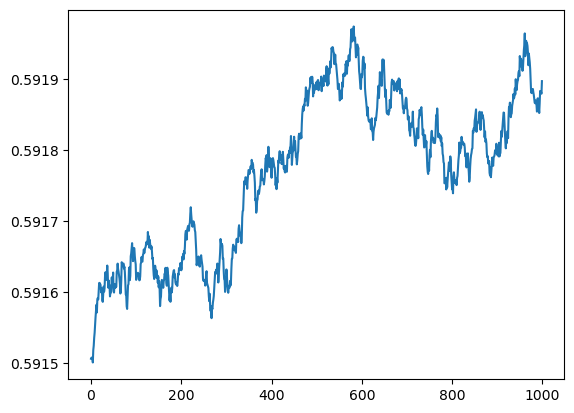

In [318]:
# plot evoluation of the norm of B
plt.plot([np.linalg.norm(B) for B in Bs])

# Learning x and B simultanously with random control

State augmentation -- this approach fails because B is unobservable so it is never updated

In [1636]:
def calc_kalman_gain_PRH(P, R, H):
    return P @ H.T @ np.linalg.inv(H @ P @ H.T + R)

In [1673]:
Q = make_random_covar([0.01, 0.0001, 0.0001], 1e-4)
A = np.eye(3)
B = np.diag([0.1, 0.3, 0.5])
control_covar = make_random_covar([0.01, 0.01, 0.01], 0.1)

P0 = 1e-3*np.eye(3)
x0 = np.random.multivariate_normal(np.zeros(3), P0)
R_coef = 2**-5

In [1674]:
# Augmented state dimension (state + B matrix elements)
augmented_state_dim = 3 + 3*3  # 3-dimensional state, 3x3 B matrix

# Initializations for the dual Kalman filter
Q_aug = np.block([[Q, np.zeros((3, 9))], [np.zeros((9, 3)), 1e-8 * np.eye(9)]]) # Augmented process noise covariance

H = np.eye(3, augmented_state_dim)  # Measurement matrix (observing only the state)

# ... (Your existing code up to the 'for' loop)

x_history = np.zeros((num_steps, 3))
X_hat_history = np.zeros((num_steps, augmented_state_dim))
y_history = np.zeros((num_steps, 3))
control_history = np.zeros((num_steps, 3))
lgg_history = np.zeros(num_steps)
P_history = np.zeros((num_steps, augmented_state_dim, augmented_state_dim))

# step 0 
x = x0
x_history[0] = x
ds = gen.sample_dataset(x, num_shots, depths)
y_rpe, lgg = analyzer.estimate_x(ds, depths)
y_history[0] = y_rpe
lgg_history[0] = lgg

# iniailization of the augmented state
X_hat = np.zeros((augmented_state_dim))  
X_hat[:3] = np.zeros(3)
X_hat[3:] = B.flatten().reshape(-1) + 0.01*np.random.randn(9) # Initialize B estimate
P = make_R(depths[lgg])*R_coef
P_aug = np.block([[P, np.zeros((3, 9))], [np.zeros((9, 3)), np.eye(9)]])

X_hat_history[0] = X_hat
P_history[0] = P_aug

# give a random kick without control to start
x = x + np.random.multivariate_normal(np.zeros(3), Q)

# step 1 to num_steps
for i in tqdm(range(1, num_steps)):
    # observe and record
    ds = gen.sample_dataset(x, num_shots, depths)
    y_rpe, lgg = analyzer.estimate_x(ds, depths)
    y_history[i] = y_rpe
    lgg_history[i] = lgg

    # make the model prediction
    Bhat = X_hat[3:].reshape(3, 3)
    G = np.vstack([Bhat, np.zeros((9, 3))])

    # Prediction
    X_hat_minus = X_hat + G @ control_history[i-1]
    P_minus = P_aug + Q_aug

    # Update
    R = make_R(depths[lgg])*R_coef
    K = calc_kalman_gain_PRH(P_minus, R, H)
    X_hat = X_hat_minus + K @ (y_rpe - H @ X_hat_minus)
    P_aug = (np.eye(augmented_state_dim) - K @ H) @ P_minus

    # Record state and B estimates
    X_hat_history[i] = X_hat
    P_history[i] = P_aug

    # select optimal control
    Bhat =  X_hat[3:].reshape(3, 3)
    x_hat = X_hat[:3].flatten()
    try:
        G_optimal, _ = discrete_infinite_horizon_lqg(A, Bhat, Q, 1e-10*np.eye(3))
    except:
        print(f'Error at step {i}')
    u_optimal = -G_optimal@x_hat
    control_history[i] = u_optimal

    # step the state
    w = np.random.multivariate_normal(np.zeros(3), Q)
    x = x + B@u_optimal + w
    x_history[i] = x

    # also step the state without control
    x_free_control_history[i] = x_free_control_history[i-1] + w    

Bhat_history = np.array([X_hat[3:].reshape(3, 3) for X_hat in X_hat_history])
xhat_history = np.array([X_hat[:3] for X_hat in X_hat_history])

  0%|          | 0/999 [00:00<?, ?it/s]

100%|██████████| 999/999 [00:10<00:00, 93.98it/s]


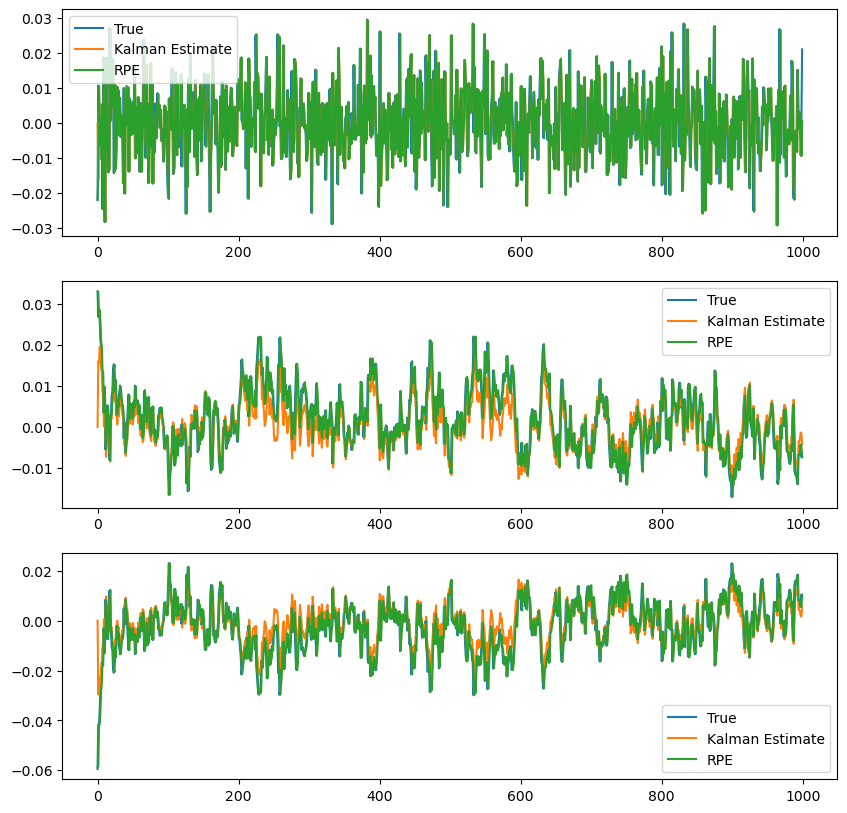

In [1676]:
plot_trajectories([x_history, xhat_history, y_history], ['True', 'Kalman Estimate', 'RPE'])

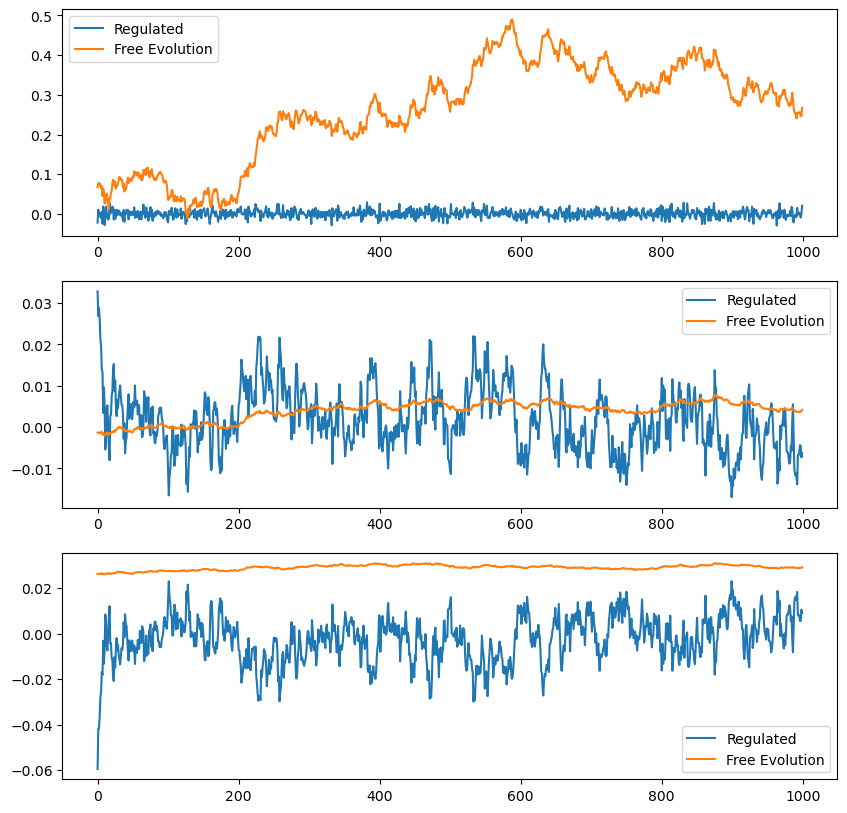

In [1677]:
plot_trajectories([x_history, x_free_control_history], ['Regulated', 'Free Evolution'])

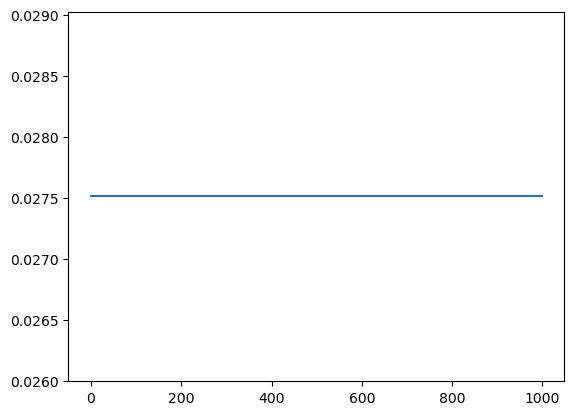

In [1680]:
Berrors = [np.linalg.norm(B - Bhat) for Bhat in Bhat_history]
plt.plot(Berrors)

----
# Scratch

In [952]:
# with reset
x_0 = np.zeros(3)
Q = 0*make_random_covar([0.00001, 0.00001, 0.00001], 1e-6)
control_covar = make_random_covar([0.1, 0.1, 0.1], 0)

B = np.diag(np.random.randn(3))

depths = [2**i for i in range(16)]

x_history_with_reset = np.zeros((num_steps, 3))
raw_rpe_history_with_reset = np.zeros((num_steps, 3))
control_history_with_reset = np.zeros((num_steps, 3))

num_steps = 1000
for n in tqdm(range(num_steps)):
    control = select_random_control(control_covar)
    x = x_0 + B @ control
    x_history_with_reset[n] = x
    control_history_with_reset[n] = control
    ds = gen.sample_dataset(x, 100, depths)
    x_est, last_good_gen = analyzer.estimate_x(ds, depths)
    raw_rpe_history_with_reset[n] = x_est


100%|██████████| 1000/1000 [00:15<00:00, 63.00it/s]


In [963]:
def make_sigma_with_reset(x_history, control_history, sigma_0):
    sigma = np.zeros((6, 6))
    for i in range(0, len(x_history)-1):
        x = x_history[i]
        u = control_history[i]
        vec = np.concatenate([x, u])
        sigma += np.outer(vec, vec)
    return sigma + sigma_0

def make_sigma_hat_with_reset(x_history, control_history):
    sigma = np.zeros((3, 6))
    for i in range(0, len(x_history)-1):
        x = x_history[i]
        u = control_history[i]
        vec = np.concatenate([x, u])
        sigma += np.outer(x_history[i+1], vec)
    return sigma

In [964]:
rmse(x_history, raw_rpe_history)

0.009849138673926472

In [965]:
def make_sigma(x_history, control_history, sigma_0):
    sigma = np.zeros((6, 6))
    for i in range(0, len(x_history)-1):
        x = x_history[i]
        u = control_history[i]
        vec = np.concatenate([x, u])
        sigma += np.outer(vec, vec)
    return sigma + sigma_0

def make_sigma_hat(x_history, control_history):
    sigma = np.zeros((3, 6))
    for i in range(0, len(x_history)-1):
        x = x_history[i]
        u = control_history[i]
        vec = np.concatenate([x, u])
        sigma += np.outer(x_history[i+1], vec)
    return sigma

In [966]:
sigma = make_sigma(x_history, control_history, 0*np.eye(6))
sigma_hat = make_sigma_hat(x_history, control_history)

In [967]:
AB = sigma_hat @ np.linalg.inv(sigma)

In [968]:
B_estimate = AB[:, 3:]
A_estimate = AB[:, :3]

In [969]:
A_estimate

array([[ 9.99809430e-01,  7.42083841e-04, -6.88998453e-04],
       [ 1.41192173e-02,  9.85046589e-01,  1.80185962e-02],
       [-3.70690780e-05, -1.63536169e-03,  1.00151504e+00]])

In [970]:
B_estimate

array([[ 0.01116728,  0.00535476,  0.00513358],
       [ 0.06344814, -0.00556492, -0.02706808],
       [-0.00142804,  0.00811069, -0.0372588 ]])

In [971]:
B

array([[0.5322697 , 0.        , 0.        ],
       [0.        , 0.90417888, 0.        ],
       [0.        , 0.        , 0.42439375]])

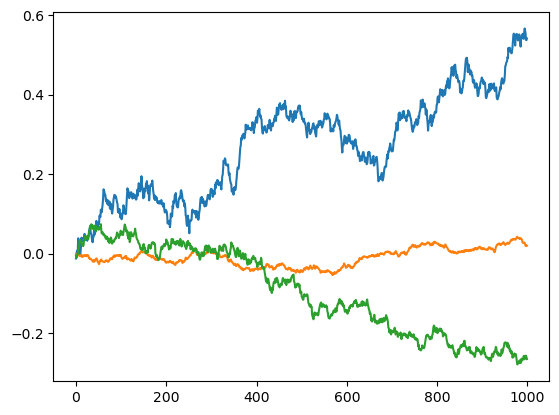

In [959]:
plt.plot(x_history)

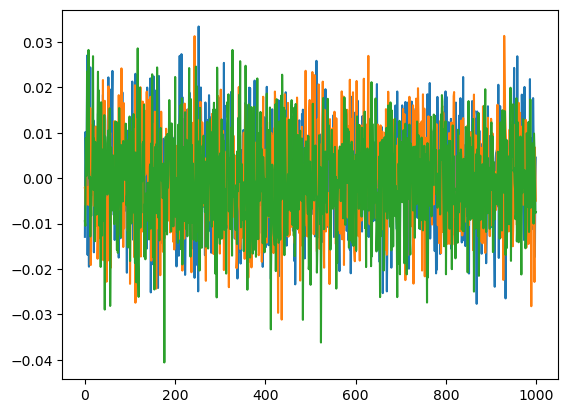

In [960]:
plt.plot(control_history)